In [929]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [930]:
DATA_DIR = os.path.join(os.path.dirname(os.getcwd()), 'data', 'stores_sales_forecasting.csv')
DATA_DIR

'c:\\Users\\PC\\Desktop\\ML-PROJECT\\HACKAVENTURE\\data\\stores_sales_forecasting.csv'

In [931]:
sales = pd.read_csv(DATA_DIR, parse_dates=['Order Date', 'Ship Date'], encoding='ISO-8859-1')
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
3,6,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-FU-10001487,Furniture,Furnishings,Eldon Expressions Wood and Plastic Desk Access...,48.8600,7,0.00,14.1694
4,11,CA-2014-115812,2014-06-09,2014-06-14,Standard Class,BH-11710,Brosina Hoffman,Consumer,United States,Los Angeles,...,90032,West,FUR-TA-10001539,Furniture,Tables,Chromcraft Rectangular Conference Tables,1706.1840,9,0.20,85.3092


In [932]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2121 entries, 0 to 2120
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         2121 non-null   int64         
 1   Order ID       2121 non-null   object        
 2   Order Date     2121 non-null   datetime64[ns]
 3   Ship Date      2121 non-null   datetime64[ns]
 4   Ship Mode      2121 non-null   object        
 5   Customer ID    2121 non-null   object        
 6   Customer Name  2121 non-null   object        
 7   Segment        2121 non-null   object        
 8   Country        2121 non-null   object        
 9   City           2121 non-null   object        
 10  State          2121 non-null   object        
 11  Postal Code    2121 non-null   int64         
 12  Region         2121 non-null   object        
 13  Product ID     2121 non-null   object        
 14  Category       2121 non-null   object        
 15  Sub-Category   2121 n

In [933]:
sales['Category'].unique()

array(['Furniture'], dtype=object)

In [934]:
sales['Sub-Category'].unique()

array(['Bookcases', 'Chairs', 'Tables', 'Furnishings'], dtype=object)

In [935]:
sales['Sub-Category'].value_counts()

Sub-Category
Furnishings    957
Chairs         617
Tables         319
Bookcases      228
Name: count, dtype: int64

In [936]:
sales = sales.loc[sales['Sub-Category'] == 'Chairs']
sales.info()

<class 'pandas.core.frame.DataFrame'>
Index: 617 entries, 1 to 2114
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         617 non-null    int64         
 1   Order ID       617 non-null    object        
 2   Order Date     617 non-null    datetime64[ns]
 3   Ship Date      617 non-null    datetime64[ns]
 4   Ship Mode      617 non-null    object        
 5   Customer ID    617 non-null    object        
 6   Customer Name  617 non-null    object        
 7   Segment        617 non-null    object        
 8   Country        617 non-null    object        
 9   City           617 non-null    object        
 10  State          617 non-null    object        
 11  Postal Code    617 non-null    int64         
 12  Region         617 non-null    object        
 13  Product ID     617 non-null    object        
 14  Category       617 non-null    object        
 15  Sub-Category   617 non-null

In [937]:
sales = sales.loc[:, ['Order Date', 'City', 'Sub-Category', 'Quantity', 'Discount']]
sales.head()

,Order Date,City,Sub-Category,Quantity,Discount
1,2016-11-08,Henderson,Chairs,3,0.0
5,2017-07-16,Philadelphia,Chairs,2,0.3
11,2015-12-27,Houston,Chairs,3,0.3
13,2015-04-18,New Albany,Chairs,1,0.0
14,2016-06-17,Troy,Chairs,5,0.1


In [938]:
sales = sales.rename(columns={
    'Order Date': 'Date',
    'Sub-Category': 'Product',
    'City': 'Address',
})
sales.head()

,Date,Address,Product,Quantity,Discount
1,2016-11-08,Henderson,Chairs,3,0.0
5,2017-07-16,Philadelphia,Chairs,2,0.3
11,2015-12-27,Houston,Chairs,3,0.3
13,2015-04-18,New Albany,Chairs,1,0.0
14,2016-06-17,Troy,Chairs,5,0.1


In [939]:
sales = sales.sort_values(by='Date', ascending=True)
sales.head()

,Date,Address,Product,Quantity,Discount
1577,2014-01-06,Henderson,Chairs,9,0.0
631,2014-01-13,Mount Pleasant,Chairs,6,0.0
234,2014-01-20,Jonesboro,Chairs,3,0.0
1955,2014-02-11,Columbia,Chairs,1,0.0
97,2014-02-12,Concord,Chairs,2,0.2


In [940]:
sales.iloc[-5:]

,Date,Address,Product,Quantity,Discount
1437,2017-12-28,Peoria,Chairs,2,0.3
1618,2017-12-29,Louisville,Chairs,1,0.0
393,2017-12-29,Los Angeles,Chairs,4,0.2
1619,2017-12-29,Louisville,Chairs,3,0.0
1617,2017-12-29,Louisville,Chairs,8,0.0


In [941]:
sales = sales.set_index('Date')
sales.head()

,Address,Product,Quantity,Discount
Date,,,,
2014-01-06,Henderson,Chairs,9,0.0
2014-01-13,Mount Pleasant,Chairs,6,0.0
2014-01-20,Jonesboro,Chairs,3,0.0
2014-02-11,Columbia,Chairs,1,0.0
2014-02-12,Concord,Chairs,2,0.2


In [942]:
sales_info = sales[['Address', 'Product']]
sales_info.head()

,Address,Product
Date,,
2014-01-06,Henderson,Chairs
2014-01-13,Mount Pleasant,Chairs
2014-01-20,Jonesboro,Chairs
2014-02-11,Columbia,Chairs
2014-02-12,Concord,Chairs


In [943]:
sales = sales.resample('D').agg({
    'Quantity': 'sum',
    'Discount': 'mean',
})
sales.head()

,Quantity,Discount
Date,,
2014-01-06,9,0.0
2014-01-07,0,NaN
2014-01-08,0,NaN
2014-01-09,0,NaN
2014-01-10,0,NaN


In [944]:
sales['Quantity'] = sales['Quantity'].fillna(0)
sales['Discount'] = sales['Discount'].fillna(0)
sales.head()

,Quantity,Discount
Date,,
2014-01-06,9,0.0
2014-01-07,0,0.0
2014-01-08,0,0.0
2014-01-09,0,0.0
2014-01-10,0,0.0


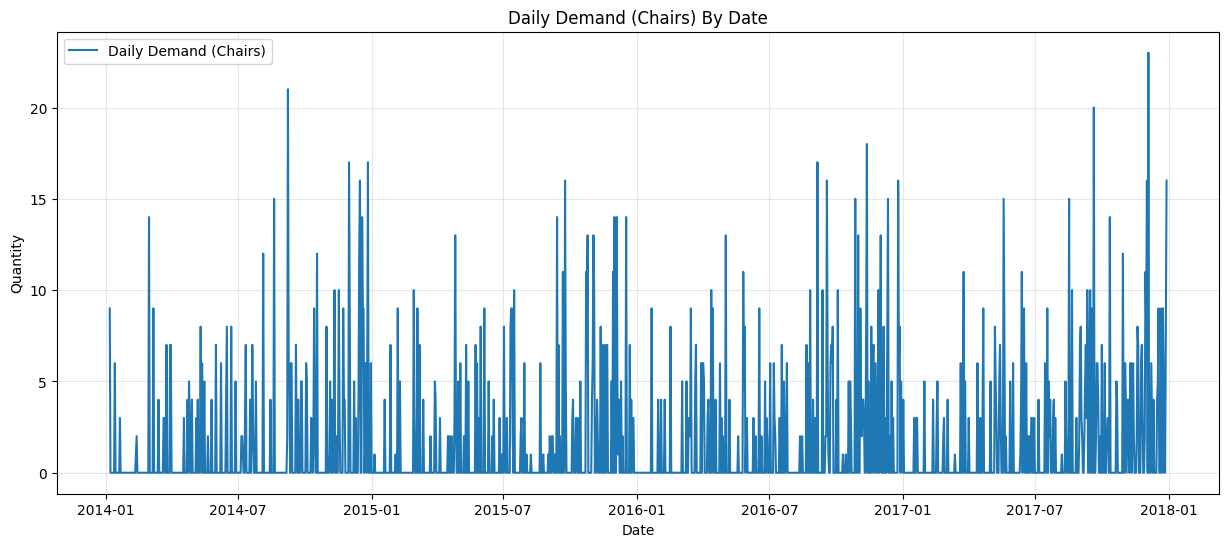

In [945]:
plt.figure(figsize=(15, 6))
plt.plot(sales.index, sales['Quantity'], label='Daily Demand (Chairs)')
plt.title('Daily Demand (Chairs) By Date')
plt.ylabel('Quantity')
plt.xlabel('Date')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [946]:
test_start_dt = '2017-12-01'

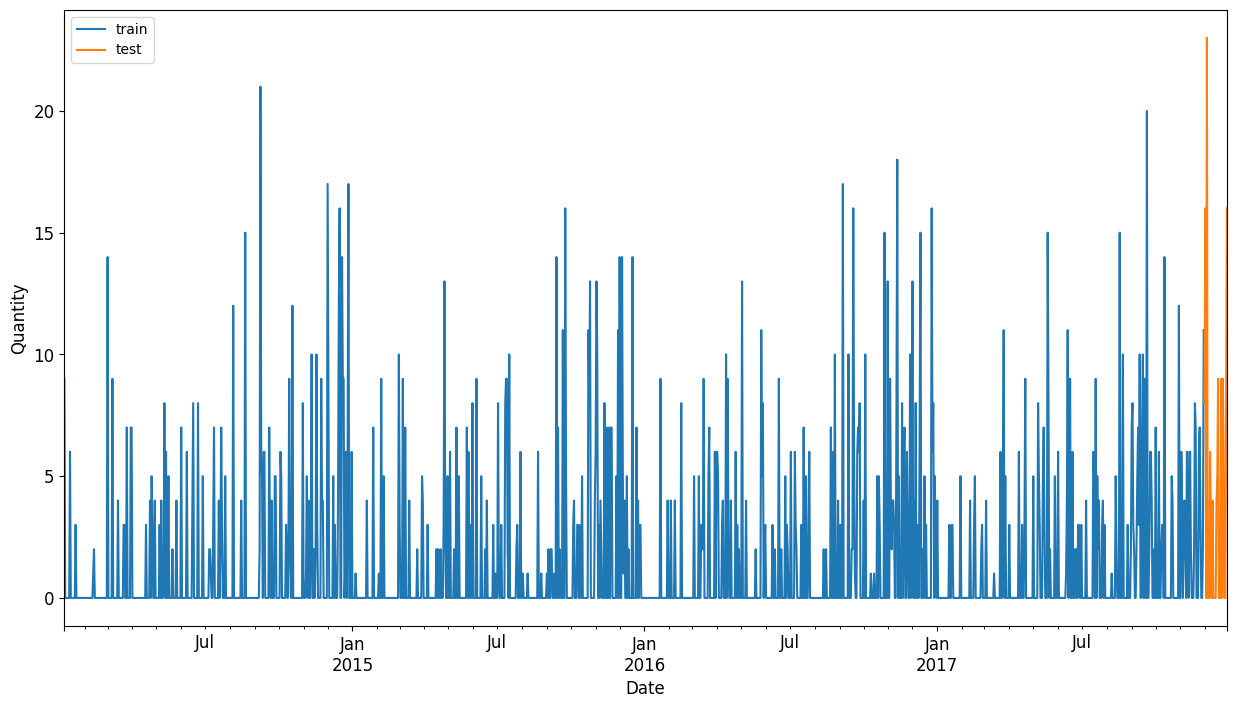

In [947]:
sales[(sales.index < test_start_dt)][['Quantity']].rename(columns={'Quantity':'train'}) \
    .join(sales[test_start_dt:][['Quantity']].rename(columns={'Quantity':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Quantity', fontsize=12)
plt.show()

In [948]:
train = sales.copy()[sales.index < test_start_dt][['Quantity', 'Discount']]
test = sales.copy()[sales.index >= test_start_dt][['Quantity', 'Discount']]
print(f'Training data shape: {train.shape}')
print(f'Testing data shape: {test.shape}')

Training data shape: (1425, 2)
Testing data shape: (29, 2)


In [949]:
scaler_y = MinMaxScaler()
train['Quantity'] = scaler_y.fit_transform(train[['Quantity']])
test['Quantity'] = scaler_y.transform(test[['Quantity']])
train.head()

,Quantity,Discount
Date,,
2014-01-06,0.428571,0.0
2014-01-07,0.000000,0.0
2014-01-08,0.000000,0.0
2014-01-09,0.000000,0.0
2014-01-10,0.000000,0.0


In [950]:
scaler_X = MinMaxScaler()
train['Discount'] = scaler_X.fit_transform(train[['Discount']])
test['Discount'] = scaler_X.transform(test[['Discount']])
test.head()

,Quantity,Discount
Date,,
2017-12-01,0.380952,0.666667
2017-12-02,0.761905,0.444444
2017-12-03,0.000000,0.000000
2017-12-04,1.095238,0.500000
2017-12-05,0.000000,0.000000


<Axes: ylabel='Frequency'>

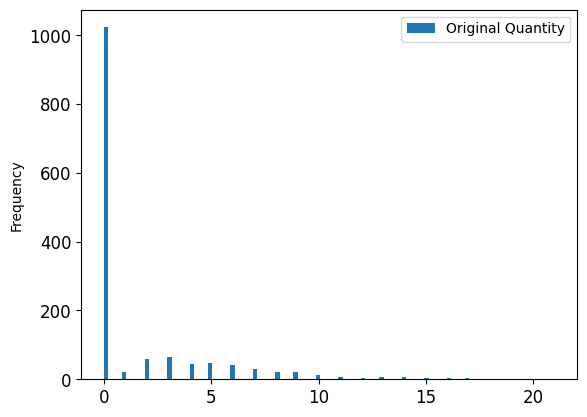

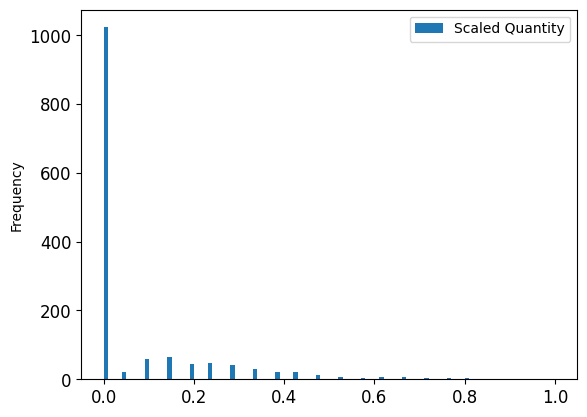

In [951]:
sales[(sales.index < test_start_dt)][['Quantity']].rename(columns={'Quantity': 'Original Quantity'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'Quantity': 'Scaled Quantity'})[['Scaled Quantity']].plot.hist(bins=100, fontsize=12)

<Axes: ylabel='Frequency'>

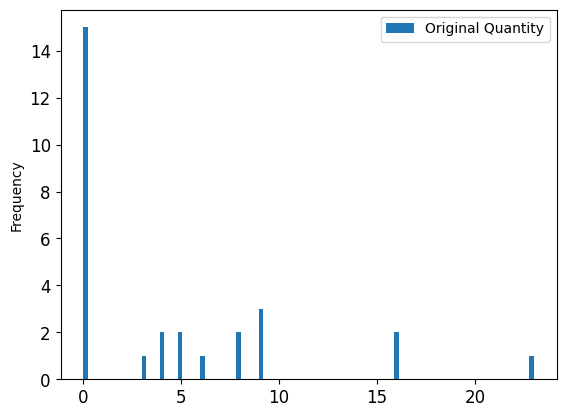

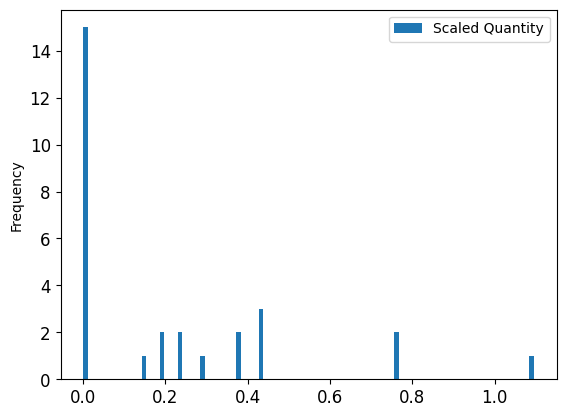

In [952]:
sales[(sales.index >= test_start_dt)][['Quantity']].rename(columns={'Quantity': 'Original Quantity'}).plot.hist(bins=100, fontsize=12)
test.rename(columns={'Quantity': 'Scaled Quantity'})[['Scaled Quantity']].plot.hist(bins=100, fontsize=12)

In [953]:
# Specify the number of steps to forecast ahead
HORIZON = 1
print('Forecasting horizon:', HORIZON, 'day')

Forecasting horizon: 1 day


In [954]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 7)

model = SARIMAX(endog=train['Quantity'], exog=train['Discount'], order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                     
Dep. Variable:                          Quantity   No. Observations:                 1425
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                1012.146
Date:                           Sun, 07 Dec 2025   AIC                          -2012.291
Time:                                   20:12:26   BIC                          -1980.753
Sample:                               01-06-2014   HQIC                         -2000.509
                                    - 11-30-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Discount       0.3072      0.008     40.645      0.000       0.292       0.322
ar.L1          0.0394      0.028      1.400

In [955]:
predictions = results.get_forecast(steps=len(test), exog=test['Discount'])
predicted_values = predictions.predicted_mean
print(predicted_values)

2017-12-01    0.255959
2017-12-02    0.166538
2017-12-03    0.037302
2017-12-04    0.198312
2017-12-05    0.034031
2017-12-06    0.019778
2017-12-07    0.042393
2017-12-08    0.296812
2017-12-09    0.030163
2017-12-10    0.037722
2017-12-11    0.317710
2017-12-12    0.034001
2017-12-13    0.019429
2017-12-14    0.043402
2017-12-15    0.040936
2017-12-16    0.235042
2017-12-17    0.037804
2017-12-18    0.147130
2017-12-19    0.034085
2017-12-20    0.019514
2017-12-21    0.043482
2017-12-22    0.041019
2017-12-23    0.030330
2017-12-24    0.140285
2017-12-25    0.044816
2017-12-26    0.034168
2017-12-27    0.019597
2017-12-28    0.299560
2017-12-29    0.092301
Freq: D, Name: predicted_mean, dtype: float64


In [956]:
predicted_values.index = test.index
predicted_values = pd.DataFrame(predicted_values)
predicted_values['predicted_mean'] = scaler_y.inverse_transform(predicted_values[['predicted_mean']])
predicted_values = predicted_values.rename(columns={'predicted_mean': 'Predicted Quantity'})
predicted_values.head()

,Predicted Quantity
Date,
2017-12-01,5.375131
2017-12-02,3.497296
2017-12-03,0.783339
2017-12-04,4.164559
2017-12-05,0.714661


In [957]:
train['Quantity'] = scaler_y.inverse_transform(train[['Quantity']])
test['Quantity'] = scaler_y.inverse_transform(test[['Quantity']])

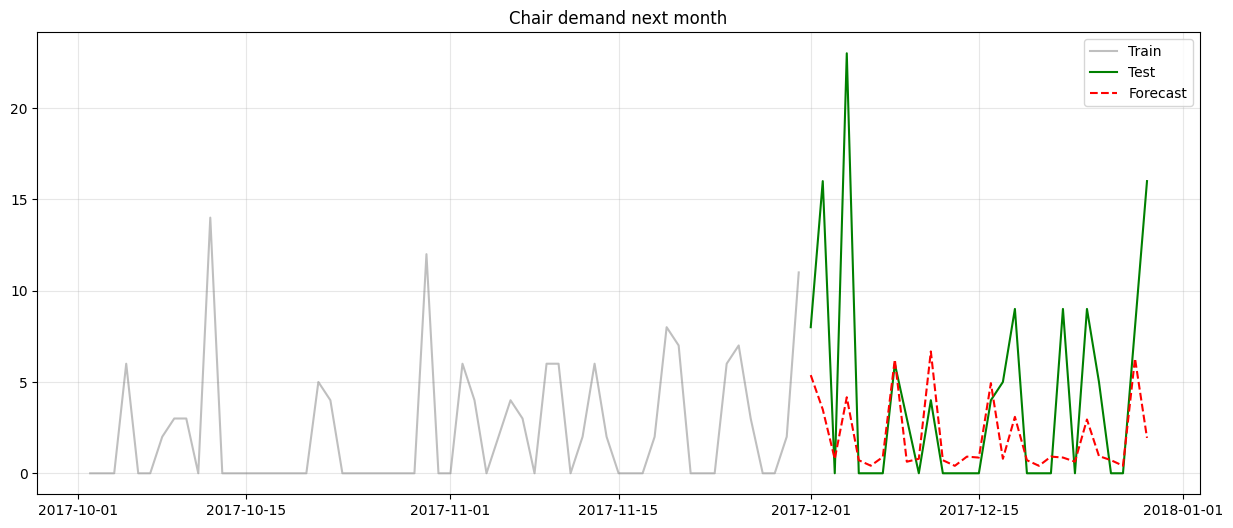

In [958]:
plt.figure(figsize=(15, 6))
plt.plot(train.index[-60:], train['Quantity'][-60:], label='Train', color='gray', alpha=0.5)
plt.plot(test.index, test['Quantity'], label='Test', color='green')
plt.plot(predicted_values.index, predicted_values, label='Forecast', color='red', linestyle='--')

plt.title('Chair demand next month')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()